In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.discriminant_analysis import StandardScaler

Using TensorFlow backend


C:\Users\joaop\AppData\Local\Temp\ipykernel_3928\2168268661.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
data = pd.read_csv("wdbc.data",header=None)
data_n = data.values
def load_data(data_n):
    X = data_n[:,2:].astype('float')
    m = X.shape[0]
    n = X.shape[1]
    y = (data_n[:,1]=="M").astype(int).astype('float')
    y = y.reshape((m,1))
    return X,y,m,n
def normalize (X_train,X_val,X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.fit_transform(X_train)
    X_val = sc.fit_transform(X_val)
    X_test = sc.fit_transform(X_test)
    return X_train,X_val,X_test

In [99]:
def get_accuracy(conf_matrix):
    tn, fp, fn, tp = np.ravel(conf_matrix)
    return (tp + tn) / (tp + tn + fp + fn)

def get_precision(conf_matrix):
    tn, fp, fn, tp = np.ravel(conf_matrix)
    return tp / (tp + fp)

def get_sensitivity(conf_matrix):
    tn, fp, fn, tp = np.ravel(conf_matrix)
    return tp / (tp + fn)
def get_specificity(conf_matrix):
    tn, fp, fn, tp = np.ravel(conf_matrix)
    return tn / (tn + fp + 1e-10)
def conf_matrix(mat):
    res = {"acc":get_accuracy(mat),"sen":get_sensitivity(mat),"spe":get_specificity(mat)}
    return pd.DataFrame(res, index=[0])

def calculate_y_hat(x, model):
    y_hat_result = model.predict(x,verbose=0)
    y_hat_result = [0 if i < 0.5 else 1 for i in y_hat_result]
    return y_hat_result

def full_conf_matrix(x_test, x_val, x_train, y_test, y_val, y_train, model):
    res = pd.DataFrame()
    y_hat_test = calculate_y_hat(x_test, model)
    conf_test = tuple(confusion_matrix(y_test, y_hat_test).reshape(1, 4)[0])
    res = pd.concat([res,conf_matrix(conf_test)])

    y_hat_train = calculate_y_hat(x_train, model)
    conf_train = tuple(confusion_matrix(y_train, y_hat_train).reshape(1, 4)[0])
    res = pd.concat([res,conf_matrix(conf_train)])

    y_hat_val = calculate_y_hat(x_val, model)
    conf_val = tuple(confusion_matrix(y_val, y_hat_val).reshape(1, 4)[0])
    res = pd.concat([res,conf_matrix(conf_val)])

    res.index = ["test","train","val"]

    return res



### Learning rate testing


In [22]:

X,y,m,n = load_data(data_n)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train, X_val,X_test = normalize(X_train, X_val,X_test)

# Define a list of learning rates
learning_rates = list(np.linspace(0.0001, 10, 100))

max_epochs = 100
# Initialize an empty list to store the losses
losses = []

# Iterate over the learning rates and train the model, recording the losses
for lr in learning_rates:
    # Create and compile the model with the current learning rate
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(30,)),
        tf.keras.layers.Dense(20, activation=tf.nn.leaky_relu,),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), loss='binary_crossentropy')

    # Train the model and record the final loss
    history = model.fit(X_train, y_train, epochs=max_epochs, verbose=0)
    losses.append(history.history['loss'][-1])



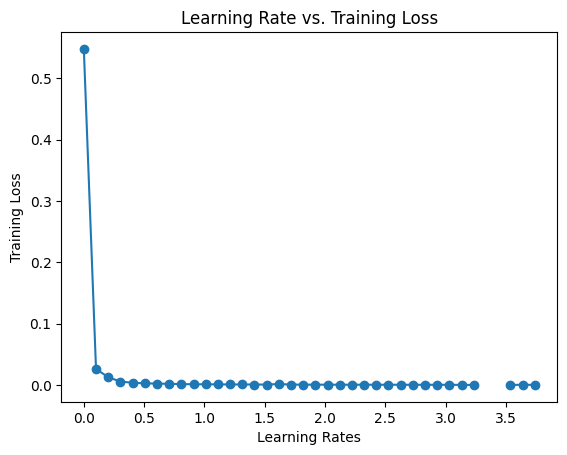

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the learning rates against the losses
plt.plot(learning_rates, losses, marker='o')
plt.xlabel('Learning Rates')
plt.ylabel('Training Loss')
plt.title('Learning Rate vs. Training Loss')
plt.show()
plt.savefig("output1")




### Cost Function

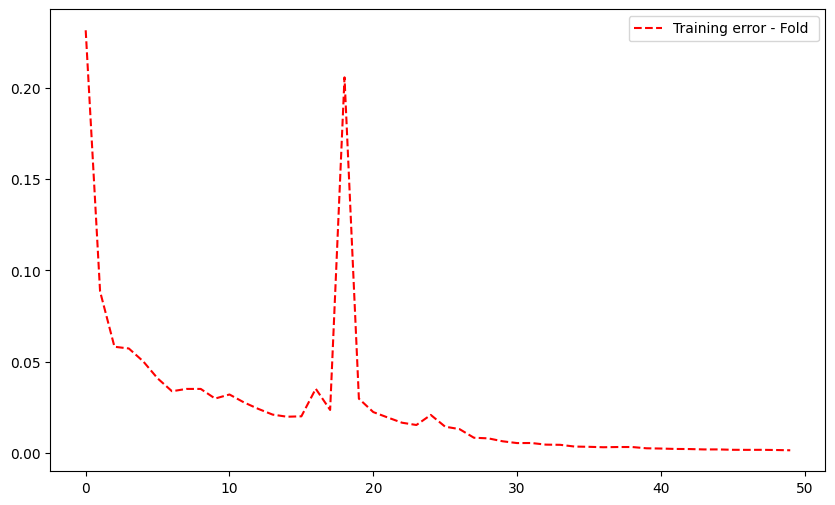

' '

In [24]:
X,y,m,n = load_data(data_n)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train, X_val,X_test = normalize(X_train, X_val,X_test)
losses = []

# Iterate over the learning rates and train the model, recording the losses

    # Create and compile the model with the current learning rate
model = tf.keras.Sequential([
    tf.keras.Input(shape=(30,)),
    tf.keras.layers.Dense(20, activation=tf.nn.leaky_relu,),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

# Train the model and record the final loss
history = model.fit(X_train, y_train, epochs=50, verbose=0)

plt.figure(figsize=(10, 6))
plt.plot(range(50), history.history["loss"], color="r", linestyle='--', label=f"Training error - Fold ")


plt.legend()
plt.show()

history.history["loss"]
" "


First Results


In [25]:
X,y,m,n = load_data(data_n)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train, X_val,X_test = normalize(X_train, X_val,X_test)
    

    # Define and compile your model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(30,)),
        tf.keras.layers.Dense(20, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid )
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

    model.fit(X_train, y_train, epochs=50, verbose=0)

    df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])


In [26]:
def mean_df(df):
    arr1 = df.iloc[0:3].to_numpy()
    arr2 = df.iloc[3:6].to_numpy()
    arr3 = df.iloc[6:9].to_numpy()
    arr4 = df.iloc[9:].to_numpy()
    
    # Compute the mean along the corresponding cells
    mean_array = (arr1 + arr2 + arr3+ arr4 ) / 4

    # Create a new DataFrame from the mean NumPy array
    return pd.DataFrame(mean_array, index=df.iloc[0:3].index, columns=df.iloc[0:3].columns)

In [27]:
mean_df(df)


,acc,sen,spe
test,0.971491,0.947674,0.985915
train,1.000000,1.000000,1.000000
val,0.967066,0.955248,0.976129


### Hidden Layer testing

In [28]:
X,y,m,n = load_data(data_n)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
accuracy_train = []
accuracy_test = []
accuracy_val = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for neurons in range(1,50):
    df = pd.DataFrame()
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, X_val,X_test = normalize(X_train, X_val,X_test)
    
        # Define and compile your model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(30,)),
            tf.keras.layers.Dense(neurons, activation=tf.nn.leaky_relu,),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, )
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

        # Train the model
        history_train = model.fit(X_train, y_train, epochs=50, verbose=0)
        history_val = model.fit(X_train, y_train, epochs=50, verbose=0)

        # Store the losses for each fold
        df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])
    accuracy_train.append(mean_df(df).iloc[1,0])
    accuracy_test.append(mean_df(df).iloc[0,0])
    accuracy_val.append(mean_df(df).iloc[2,0])

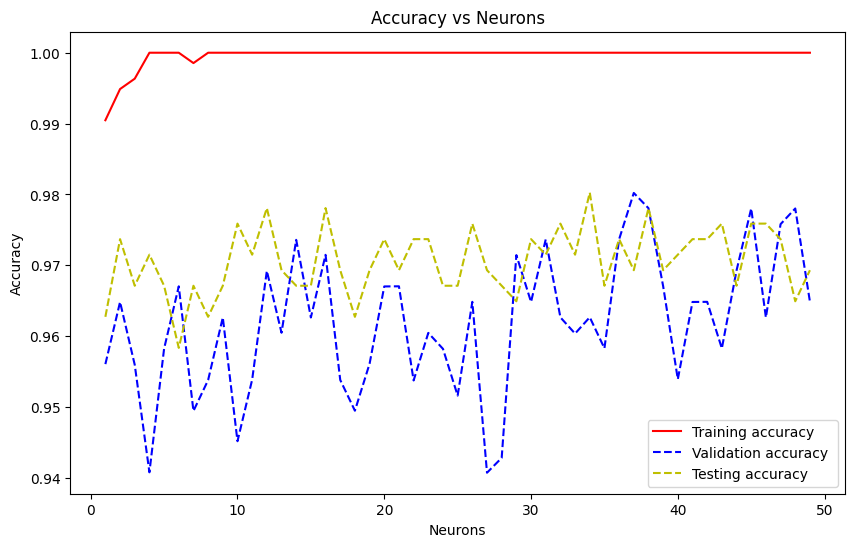

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,50),accuracy_train, color="r", linestyle='-', label=f"Training accuracy ")
plt.plot(range(1,50),accuracy_val, color="b", linestyle='--', label=f"Validation accuracy ")
plt.plot(range(1,50),accuracy_test, color="y", linestyle='--', label=f"Testing accuracy ")

plt.title('Accuracy vs Neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
mean_df(df)

,acc,sen,spe
test,0.969298,0.947674,0.982394
train,1.000000,1.000000,1.000000
val,0.964854,0.941809,0.980199


### Activation functions testing

In [45]:
activation_functions = [
    tf.nn.relu,
    tf.nn.relu6,
    tf.nn.crelu,
    tf.nn.elu,
    tf.nn.selu,
    tf.nn.softplus,
    tf.nn.softsign,
    tf.nn.leaky_relu
]


X,y,m,n = load_data(data_n)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
accuracy_train = []
accuracy_test = []
accuracy_val = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for a_f in activation_functions:
    df = pd.DataFrame()
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, X_val,X_test = normalize(X_train, X_val,X_test)

        # Define and compile your model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(30,)),
            tf.keras.layers.Dense(26, activation=a_f),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, )
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

        # Train the model
        history_train = model.fit(X_train, y_train, epochs=50, verbose=0)
        history_val = model.fit(X_train, y_train, epochs=50, verbose=0)

        # Store the losses for each fold
        df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])
    accuracy_train.append(mean_df(df).iloc[1,0])
    accuracy_test.append(mean_df(df).iloc[0,0])
    accuracy_val.append(mean_df(df).iloc[2,0])

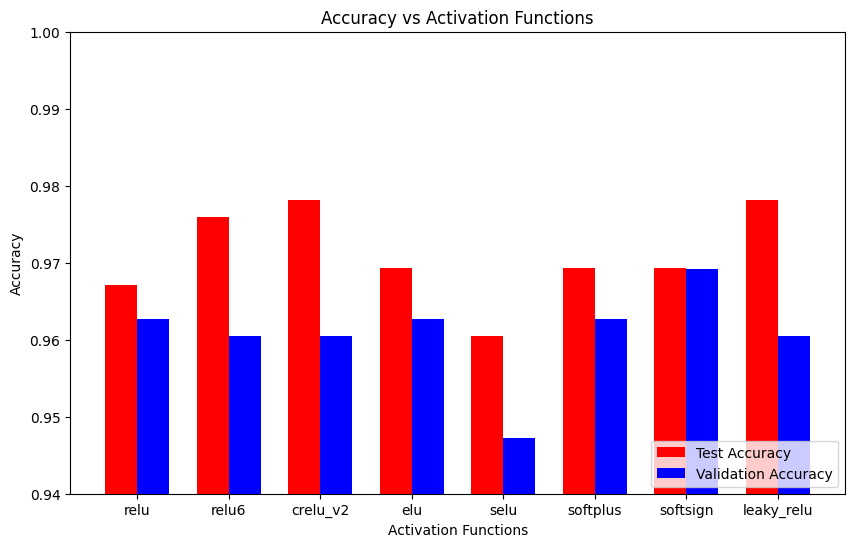

In [97]:
activation_functions = [str(activation).split(' ')[1] for activation in activation_functions]
width = 0.35  
x = np.arange(len(activation_functions))

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, accuracy_test, width, label='Test Accuracy', color='red')
rects2 = ax.bar(x + width / 2, accuracy_val, width, label='Validation Accuracy', color='blue')

ax.set_xlabel('Activation Functions')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Activation Functions')
ax.set_xticks(x)
ax.set_ylim(0.94,1.0)
ax.set_xticklabels(activation_functions)
ax.legend(loc='lower right')
plt.show()

#### Learning curve

In [102]:
X,y,m,n = load_data(data_n)

# Define different training set sizes
train_sizes = np.linspace(0.05,1,20)

# Initialize lists to store results
train_losses = []
val_losses = []
mean_train_losses_plot = []
mean_val_losses_plot = []
X1, X_test, y1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Perform cross-validation for different training set sizes
for size in train_sizes:
    X = X1
    y = y1
    if size !=1:
        X, _, y, _ = train_test_split(X, y, train_size=size, random_state=42)



    # Define the number of folds
    k = 4
    kf = KFold(n_splits=k, shuffle=True)

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    tests = []
    df = pd.DataFrame()
    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, X_val,X_test = normalize(X_train, X_val,X_test)

        # Define and compile your model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(30,)),
            tf.keras.layers.Dense(26, activation=tf.nn.leaky_relu,),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, )
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

        # Train the model
        history_train = model.fit(X_train, y_train, epochs=50, verbose=0)
        history_val = model.fit(X_train, y_train, epochs=50, verbose=0,validation_data=(X_val,y_val))
        # Store the losses for each fold
        train_losses.append(history_train.history["loss"])
        val_losses.append(history_val.history["val_loss"])
        df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])
        #print(full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model))
    
    mean_train_losses = np.mean(train_losses, axis=0)
    mean_val_losses = np.mean(val_losses, axis=0)

    mean_train_losses_plot.append(np.mean(train_losses, axis=0)[-1])
    mean_val_losses_plot.append(np.mean(val_losses, axis=0)[-1])



C:\Users\joaop\AppData\Local\Temp\ipykernel_19432\993327664.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fn)


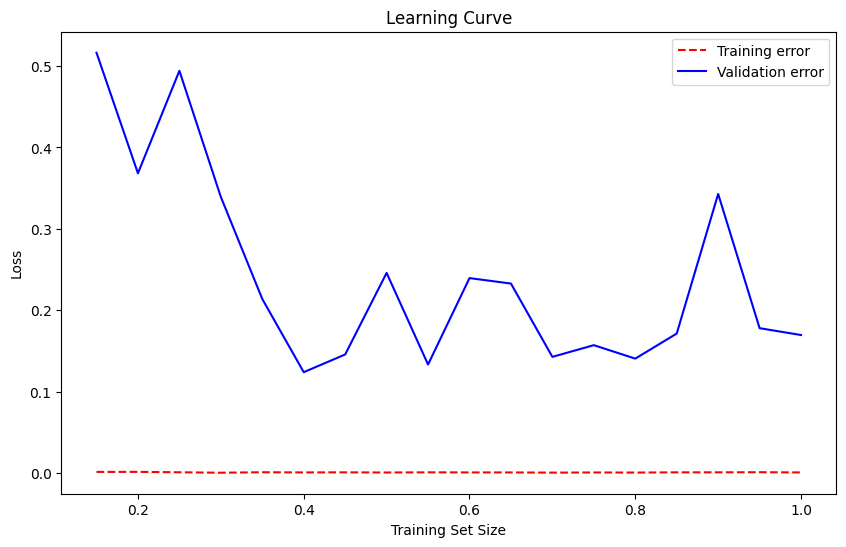

In [103]:
# Create learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes[2:],  mean_train_losses_plot[2:], color="r", linestyle='--', label=f"Training error ")
plt.plot(train_sizes[2:], mean_val_losses_plot[2:], color="b", linestyle='-', label=f"Validation error")

# Add title and labels
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Regularazation

In [35]:
X,y,m,n = load_data(data_n)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)
lambdas = np.linspace(0,0.1,100)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
accuracy_train = []
accuracy_test = []
accuracy_val = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for l in lambdas:
    df = pd.DataFrame()
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, X_val,X_test = normalize(X_train, X_val,X_test)

        # Define and compile your model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(30,)),
            tf.keras.layers.Dense(26, activation=tf.nn.leaky_relu, kernel_regularizer=tf.keras.regularizers.l1(l)),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l1(l) )
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

        # Train the model
        history_train = model.fit(X_train, y_train, epochs=50, verbose=0)
        history_val = model.fit(X_train, y_train, epochs=50, verbose=0)

        # Store the losses for each fold
        df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])
    accuracy_train.append(mean_df(df).iloc[1,0])
    accuracy_test.append(mean_df(df).iloc[0,0])
    accuracy_val.append(mean_df(df).iloc[2,0])

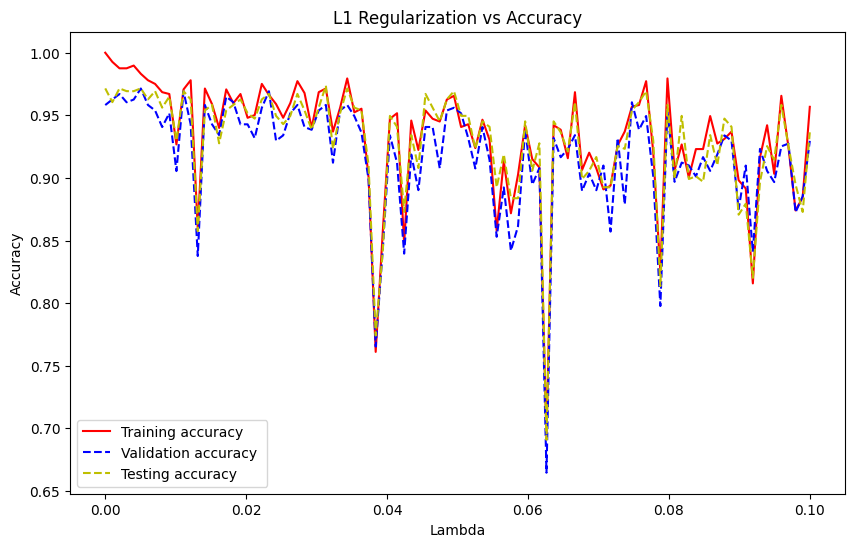

array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0.01010101, 0.01111111, 0.01212121, 0.01313131, 0.01414141,
       0.01515152, 0.01616162, 0.01717172, 0.01818182, 0.01919192,
       0.02020202, 0.02121212, 0.02222222, 0.02323232, 0.02424242,
       0.02525253, 0.02626263, 0.02727273, 0.02828283, 0.02929293,
       0.03030303, 0.03131313, 0.03232323, 0.03333333, 0.03434343,
       0.03535354, 0.03636364, 0.03737374, 0.03838384, 0.03939394,
       0.04040404, 0.04141414, 0.04242424, 0.04343434, 0.04444444,
       0.04545455, 0.04646465, 0.04747475, 0.04848485, 0.04949495,
       0.05050505, 0.05151515, 0.05252525, 0.05353535, 0.05454545,
       0.05555556, 0.05656566, 0.05757576, 0.05858586, 0.05959596,
       0.06060606, 0.06161616, 0.06262626, 0.06363636, 0.06464646,
       0.06565657, 0.06666667, 0.06767677, 0.06868687, 0.06969697,
       0.07070707, 0.07171717, 0.07272727, 0.07373737, 0.07474

In [36]:


plt.figure(figsize=(10, 6))
plt.plot(lambdas,accuracy_train, color="r", linestyle='-', label=f"Training accuracy ")
plt.plot(lambdas,accuracy_val, color="b", linestyle='--', label=f"Validation accuracy ")
plt.plot(lambdas,accuracy_test, color="y", linestyle='--', label=f"Testing accuracy ")
#plt.plot(train_sizes, mean_val_losses_plot, color="b", linestyle='-', label=f"Validation error")

# Add title and labels
plt.title('L1 Regularization vs Accuracy')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [37]:
X,y,m,n = load_data(data_n)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)
lambdas = np.linspace(0,0.1,100)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
accuracy_train = []
accuracy_test = []
accuracy_val = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for l in lambdas:
    df = pd.DataFrame()
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, X_val,X_test = normalize(X_train, X_val,X_test)

        # Define and compile your model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(30,)),
            tf.keras.layers.Dense(26, activation=tf.nn.leaky_relu, kernel_regularizer=tf.keras.regularizers.l2(l)),
            tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l2(l) )
        ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

        # Train the model
        history_train = model.fit(X_train, y_train, epochs=50, verbose=0)
        history_val = model.fit(X_train, y_train, epochs=50, verbose=0)

        # Store the losses for each fold
        df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])
    accuracy_train.append(mean_df(df).iloc[1,0])
    accuracy_test.append(mean_df(df).iloc[0,0])
    accuracy_val.append(mean_df(df).iloc[2,0])

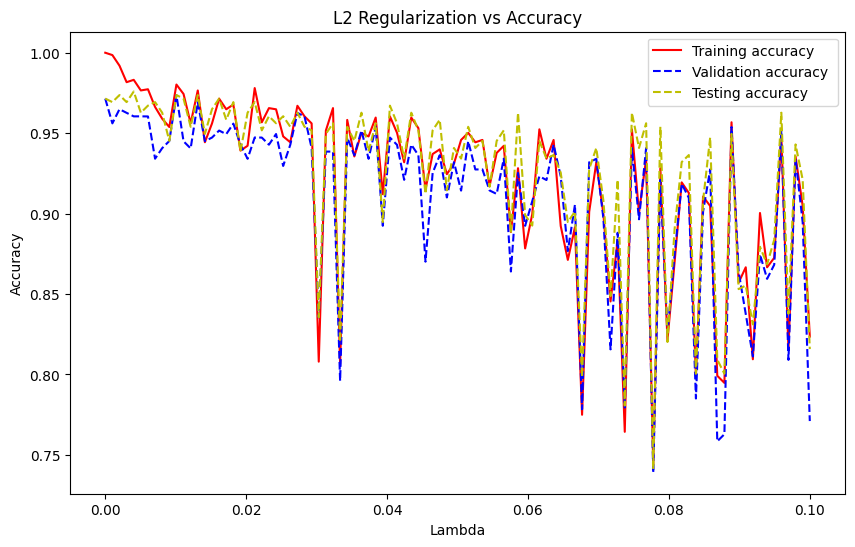

In [38]:


plt.figure(figsize=(10, 6))
plt.plot(lambdas,accuracy_train, color="r", linestyle='-', label=f"Training accuracy ")
plt.plot(lambdas,accuracy_val, color="b", linestyle='--', label=f"Validation accuracy ")
plt.plot(lambdas,accuracy_test, color="y", linestyle='--', label=f"Testing accuracy ")
#plt.plot(train_sizes, mean_val_losses_plot, color="b", linestyle='-', label=f"Validation error")

# Add title and labels
plt.title('L2 Regularization vs Accuracy')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
X,y,m,n = load_data(data_n)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds
k = 4
kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store results
train_losses = []
val_losses = []
tests = []
df = pd.DataFrame()
# Perform k-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train, X_val,X_test = normalize(X_train, X_val,X_test)
    

    # Define and compile your model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(30,)),
        tf.keras.layers.Dense(26, activation=tf.nn.leaky_relu,kernel_regularizer=tf.keras.regularizers.l2(0.002)),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid,kernel_regularizer=tf.keras.regularizers.l2(0.002) )
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0), loss='binary_crossentropy')

    # Train the model
    model.fit(X_train, y_train, epochs=50, verbose=0)
    df = pd.concat([df,full_conf_matrix(X_test,X_val,X_train,y_test,y_val,y_train,model)])


(69, 2, 4, 39)
(71, 0, 2, 41)
(71, 0, 3, 40)
(71, 0, 3, 40)


In [86]:
mean_df(df)
model

### Roc curve

0.9651162790697674

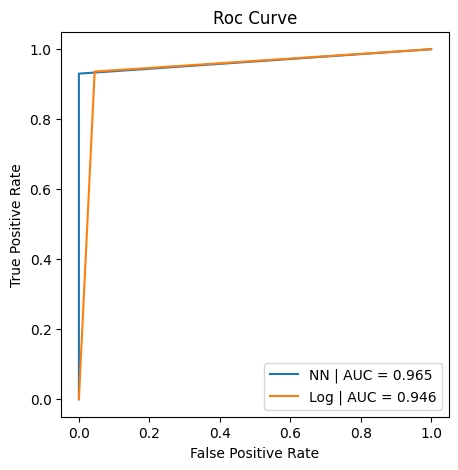

In [96]:
y_test_log = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0]

log_pred = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0]

pred = calculate_y_hat(X_test, model)
fpr,tpr,threshold = roc_curve (y_test,pred)
auc_nn = auc(fpr,tpr)


fpr_log,tpr_log,threshold = roc_curve (y_test_log,log_pred)
auc_log = auc(fpr_log,tpr_log)

plt.figure(figsize = (5,5),dpi =100)
plt.plot(fpr,tpr,label = "NN | AUC = "+str(np.round(auc_nn,3)))
plt.plot(fpr_log,tpr_log,label = "Log | AUC = "+str(np.round(auc_log,3)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Roc Curve")
auc_nn